In [1]:
#STUDENT NAME - JEEVA HARIDAS
#STUDENT ID - C0936005

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib


In [2]:
from google.colab import files
uploaded = files.upload()  # Upload your 'vehicle.csv' file here

df = pd.read_csv('vehicle.csv')  # Make sure the uploaded filename matches

Saving vehicle.csv to vehicle.csv


In [3]:
# Step 3: Preprocessing
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)


In [4]:
# Create new feature: car_age
df['car_age'] = 2025 - df['year']
df.drop(columns=['year', 'name'], inplace=True)

In [5]:
# Encode categorical features
df = pd.get_dummies(df, columns=['fuel', 'seller_type', 'transmission', 'owner'], drop_first=True)


In [6]:
# Define features and target
X = df.drop('selling_price', axis=1)
y = df['selling_price']


In [7]:
# Step 4: Split and Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# Step 5: Define Models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1)
}


In [9]:
# Step 6: Train, Evaluate, and Cross-Validate
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    try:
        cv_rmse = np.mean(np.sqrt(-cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)))
        cv_r2 = np.mean(cross_val_score(model, X, y, cv=5, scoring='r2', n_jobs=-1))
    except:
        cv_rmse = None
        cv_r2 = None

    results.append({
        "Model": name,
        "R2 Score": round(r2, 3),
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "CV R2": round(cv_r2, 3) if cv_r2 else None,
        "CV RMSE": round(cv_rmse, 2) if cv_rmse else None
    })


In [10]:
# Step 7: Model Comparison Table
results_df = pd.DataFrame(results).sort_values(by='CV RMSE', na_position='last')
print("\nModel Comparison Table:\n", results_df)



Model Comparison Table:
                Model  R2 Score        MAE       RMSE  CV R2    CV RMSE
1   Ridge Regression     0.393  213056.88  442308.86  0.423  376182.17
0  Linear Regression     0.393  213071.18  442304.97  0.421  376516.89
2      Random Forest     0.441  192924.69  424329.18  0.420  378023.85
3            XGBoost     0.399  193612.58  440019.84  0.339  404591.18


In [11]:
# Step 8: Save Best Model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
joblib.dump({'model': best_model, 'scaler': scaler}, 'best_used_car_model.pkl')
print(f"\n✅ Saved best model: {best_model_name} to 'best_used_car_model.pkl'")



✅ Saved best model: Ridge Regression to 'best_used_car_model.pkl'


In [12]:
# Step 9: Load and Predict Example
loaded = joblib.load("best_used_car_model.pkl")
model = loaded['model']
scaler = loaded['scaler']

sample_input = pd.DataFrame([X.iloc[0]])  # one example row
scaled_input = scaler.transform(sample_input)
predicted_price = model.predict(scaled_input)
print(f"\nPredicted price for sample input: ₹{predicted_price[0]:,.2f}")


Predicted price for sample input: ₹82,361.82


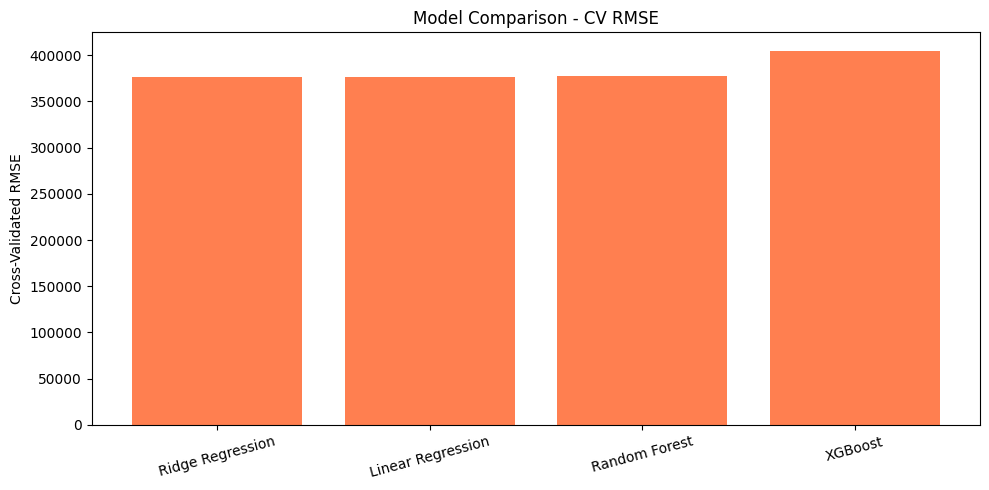

In [13]:
# Step 10: Bar Chart for Visual Comparison
plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["CV RMSE"], color='coral')
plt.title("Model Comparison - CV RMSE")
plt.ylabel("Cross-Validated RMSE")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()